# Описание проекта

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Вам предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов.

# Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    visits, orders, costs = (
    pd.read_csv('visits_info_short.csv'),  # журнал сессий
    pd.read_csv('orders_info_short.csv'),  # покупки
    pd.read_csv('costs_info_short.csv')  # траты на рекламу
)
except FileNotFoundError:
    visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

In [3]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пропусков нет, но названия у полей так себе

In [5]:
visits.columns = visits.columns.str.lower()
visits.rename(columns={'user id': 'user_id', 'session start': 'session_start', 'session end': 'session_end'}, inplace=True)

Сделаем поля с датами типом DateTime

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [7]:
visits.duplicated().sum()

0

Дубликатов нет

In [8]:
for col in visits.columns:
    pct_missing = np.mean(visits[col].isna())
    print(f'{col} - {pct_missing:.02%}')

user_id - 0.00%
region - 0.00%
device - 0.00%
channel - 0.00%
session_start - 0.00%
session_end - 0.00%


Пропусков нет

In [9]:
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [10]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


С данными о посещениях теперь можно работать

In [11]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [12]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Поменяем название полей

In [13]:
orders.head(1)

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99


In [14]:
orders.columns = orders.columns.str.lower()
orders.rename(columns={'user id': 'user_id', 'event dt': 'event_dt'}, inplace=True)

Сделаем даты - датами

In [15]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [16]:
orders.duplicated().sum()

0

In [17]:
for col in orders.columns:
    pct_missing = np.mean(orders[col].isna())
    print(f'{col} - {pct_missing:.02%}')

user_id - 0.00%
event_dt - 0.00%
revenue - 0.00%


In [18]:
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


Даты стали датами, название полей - норм, пропусков нет, дубликатов нет, можно работать

In [20]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [21]:
costs.columns = costs.columns.str.lower()
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
for col in orders.columns:
    pct_missing = np.mean(orders[col].isna())
    print(f'{col} - {pct_missing:.02%}')
orders.duplicated().sum()

user_id - 0.00%
event_dt - 0.00%
revenue - 0.00%


0

In [22]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


С данными о стоимости рекламных компаний тоже можно работать

# функции для расчета и анализа LTV, ROI, удержания и конверсии

In [23]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [24]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [25]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [26]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

А также функции для визуализации этих метрик — filter_data(), plot_retention()
, plot_conversion() и plot_ltv_roi().

In [27]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [28]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [29]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [30]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

# Исследовательский анализ данных

### Пользовательские профили. Минимальная и максимальная даты привлечения пользователей

In [31]:
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [32]:
min_date, max_date =  str(profiles['first_ts'].min())[0:-9], str(profiles['first_ts'].max())[0:-9]

In [33]:
print(f'Имеюся данные о привлеченных пользователях с {min_date} по {max_date}')

Имеюся данные о привлеченных пользователях с 2019-05-01 по 2019-10-27


### из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Таблица, отражающую количество пользователей и долю платящих из каждой страны

In [34]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [35]:
user_counts = (
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'})
    .rename(columns={'user_id': 'user_counts', 'payer': 'payer_counts'})
    .sort_values(by='payer_counts', ascending=False)
)
user_counts['payers_%'] = round(user_counts['payer_counts'] / user_counts['user_counts'] * 100,2)
user_counts

,user_counts,payer_counts,payers_%
region,,,
United States,100002,6902,6.90
UK,17575,700,3.98
France,17450,663,3.80
Germany,14981,616,4.11


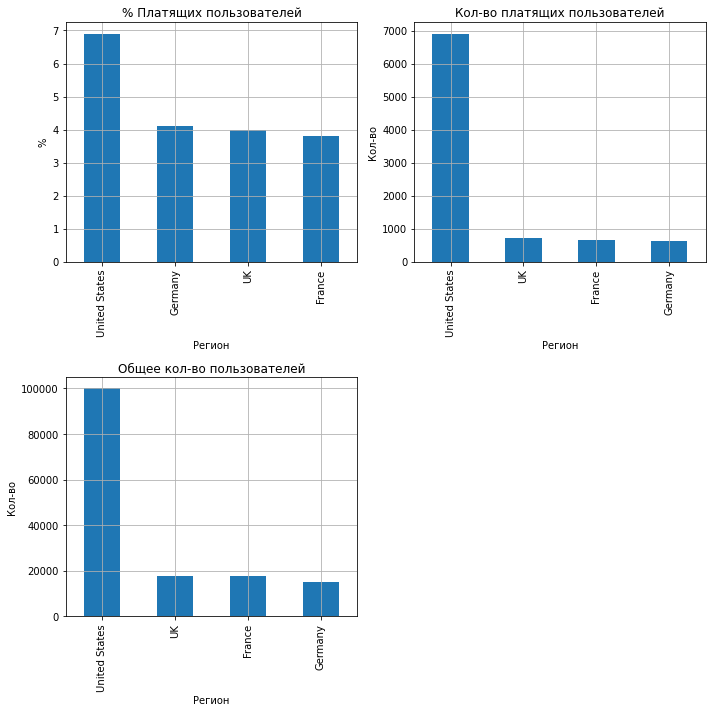

In [36]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(2, 2, 1)
user_counts['payers_%'].sort_values(ascending=False).plot(kind='bar', grid=True, ax=ax1, title='% Платящих пользователей')
plt.ylabel('%')
plt.xlabel('Регион')
ax2 = plt.subplot(2, 2, 2)
user_counts['payer_counts'].sort_values(ascending=False).plot(kind='bar', grid=True, ax=ax2, title='Кол-во платящих пользователей')
plt.ylabel('Кол-во')
plt.xlabel('Регион')
ax3 = plt.subplot(2, 2, 3)
user_counts['user_counts'].sort_values(ascending=False).plot(kind='bar', grid=True, ax=ax3, title='Общее кол-во пользователей')
plt.ylabel('Кол-во')
plt.xlabel('Регион')
plt.tight_layout()
plt.show()

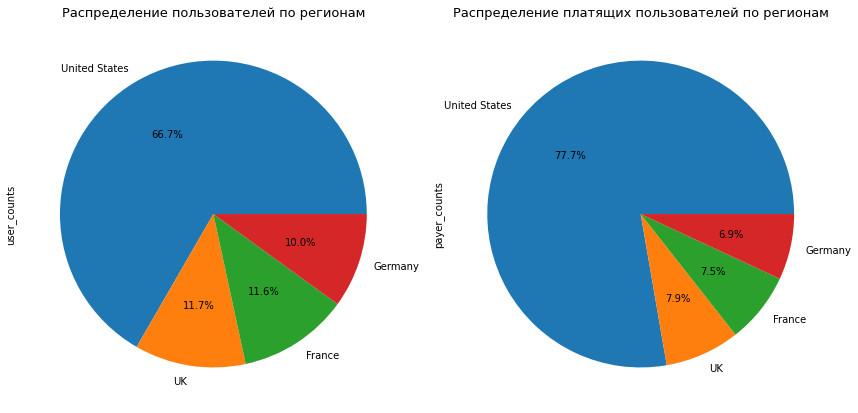

In [37]:
plt.figure(figsize=(12,12))
ax1 = plt.subplot(2, 2, 1)
user_counts['user_counts'].sort_values(ascending=False).plot(kind='pie',
                                 autopct='%1.1f%%',
                                 fontsize=10,
                                 ax=ax1)    
plt.title(f'Распределение пользователей по регионам', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
user_counts['payer_counts'].sort_values(ascending=False).plot(kind='pie',
                                 autopct='%1.1f%%',
                                 fontsize=10,
                                 ax=ax2)    
plt.title(f'Распределение платящих пользователей по регионам', fontsize=13)
plt.tight_layout()
plt.show();

- Больше всего пользователей из Америки, больше чем 100к, в этомже регионе больше всего платящих пользователй и самая высокая конверсия - 6,9%. Данный регион имеет почти 70% всех пользователей приложения и почти 80% всех платящих пользователей.
- На втором месте по количеству пользователей и платящих пользователей идет Англия, однако по конверсии данный регион занимает 3-е место
- Франция по количеству пользователей и платящих пользователей находится на третьем мест и конвертируется хуже всех
- В Германии меньше всех пользователей всех видов, однако конверсия выше чем у Франции

У Англии, Франции и Германии примерно по 10 - 11% пользователей от общего количества и от 7-8% платящих от общего количества платящих пользователей

### Какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Таблицу, отражающая количество пользователей и долю платящих для каждого устройства

In [38]:
user_counts = (
profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'})
    .rename(columns={'user_id': 'user_counts', 'payer': 'payer_counts'})
    .sort_values(by='payer_counts', ascending=False)
)
user_counts['payers_%'] = round(user_counts['payer_counts'] / user_counts['user_counts'] * 100,2)
user_counts

,user_counts,payer_counts,payers_%
device,,,
iPhone,54479,3382,6.21
Android,35032,2050,5.85
Mac,30042,1912,6.36
PC,30455,1537,5.05


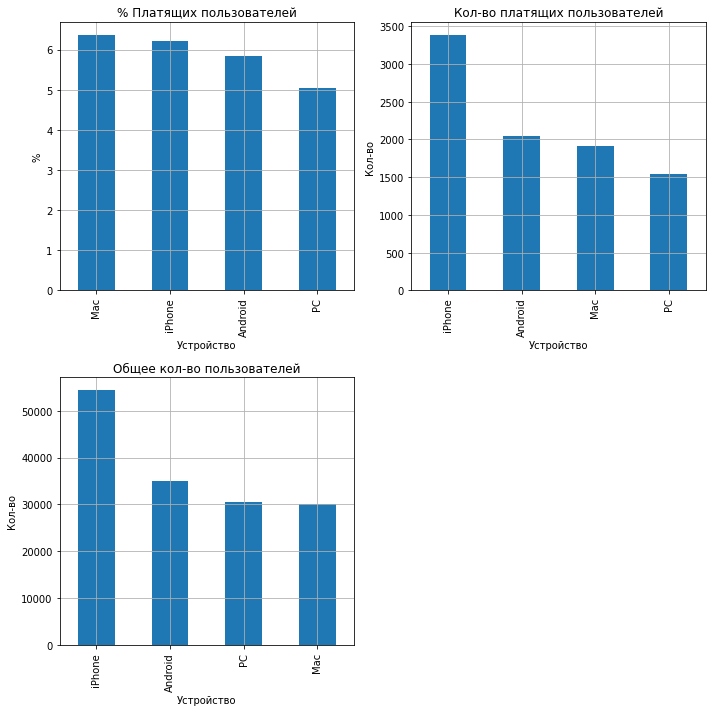

In [39]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(2, 2, 1)
user_counts['payers_%'].sort_values(ascending=False).plot(kind='bar', grid=True, ax=ax1, title='% Платящих пользователей')
plt.ylabel('%')
plt.xlabel('Устройство')
ax2 = plt.subplot(2, 2, 2)
user_counts['payer_counts'].sort_values(ascending=False).plot(kind='bar', grid=True, ax=ax2, title='Кол-во платящих пользователей')
plt.ylabel('Кол-во')
plt.xlabel('Устройство')
ax3 = plt.subplot(2, 2, 3)
user_counts['user_counts'].sort_values(ascending=False).plot(kind='bar', grid=True, ax=ax3, title='Общее кол-во пользователей')
plt.ylabel('Кол-во')
plt.xlabel('Устройство')
plt.tight_layout()
plt.show()

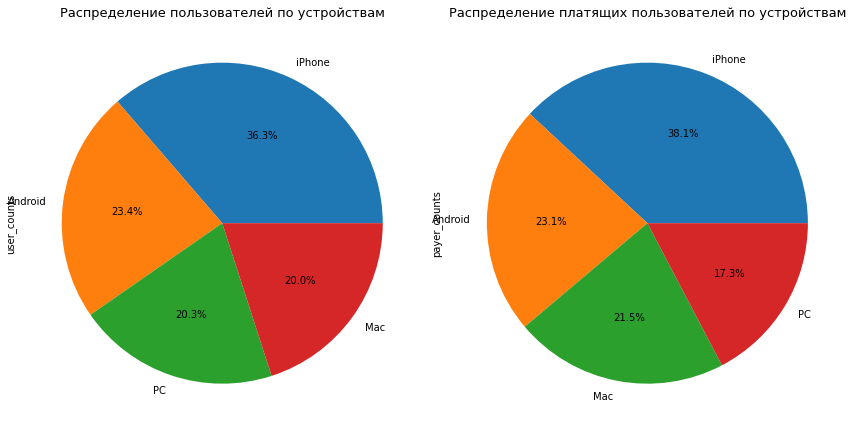

In [40]:
plt.figure(figsize=(12,12))
ax1 = plt.subplot(2, 2, 1)
user_counts['user_counts'].sort_values(ascending=False).plot(kind='pie',
                                 autopct='%1.1f%%',
                                 fontsize=10,
                                 ax=ax1)    
plt.title(f'Распределение пользователей по устройствам', fontsize=13)

ax2 = plt.subplot(2, 2, 2)
user_counts['payer_counts'].sort_values(ascending=False).plot(kind='pie',
                                 autopct='%1.1f%%',
                                 fontsize=10,
                                 ax=ax2)    
plt.title(f'Распределение платящих пользователей по устройствам', fontsize=13)
plt.tight_layout()
plt.show();

- Наибольшее число пользователей, предпочитают IPhone, с этого же устройства заходят в приложения и большинство платящих юзеров по количеству, но не по конверсии. Первое место по конверсии занимают пользователи MAC.
- На втором месте по обоим показателям (общее количество и количество платящих пользователей) занимает Android, по конверсии данная платформа на 3-ем месте.
- На третьем месте идет Mac, но у него самая высокая конвертируемость в платных юзеров.
- PC на последнем месте по всем показателям

In [41]:
user_counts = (
    profiles.groupby(['region', 'device']).agg({'user_id': 'nunique', 'payer': 'sum'}).rename(columns={'user_id': 'user_counts', 'payer': 'payer_counts'})
    .sort_values(by=(['region','payer_counts']), ascending=False)
)
user_counts['payers_%'] = round(user_counts['payer_counts'] / user_counts['user_counts'] * 100,2)
user_counts

user_counts  payer_counts  payers_%
region        device                                      
United States iPhone         44529          2994      6.72
              Mac            24842          1706      6.87
              Android        20199          1487      7.36
              PC             10432           715      6.85
UK            PC              7138           301      4.22
              Android         5141           202      3.93
              iPhone          3518           134      3.81
              Mac             1778            63      3.54
Germany       PC              5945           253      4.26
              Android         4440           182      4.10
              iPhone          3012           120      3.98
              Mac             1584            61      3.85
France        PC              6940           268      3.86
              Android         5252           179      3.41
              iPhone          3420           134      3.92
              Mac             1838            82      4.46

Если смотреть в разрере регионов, то ситуация следующая:
- В Америки предпочитают Iphone, но лучше всего конвертируются с Android
- В Европе больше всего пользователей на ПК, и они же, везде, кроме Франции лучше всего конвертируются.

## Рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [42]:
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [43]:
user_counts = (
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum', 'acquisition_cost' : 'mean'})
    .rename(columns={'user_id': 'user_counts', 'payer': 'payer_counts'})
    .sort_values(by='payer_counts', ascending=False)
)
user_counts['payers_%'] = round(user_counts['payer_counts'] / user_counts['user_counts'] * 100,2)
user_counts

,user_counts,payer_counts,acquisition_cost,payers_%
channel,,,,
FaceBoom,29144,3557,1.113286,12.20
TipTop,19561,1878,2.799003,9.60
organic,56439,1160,0.000000,2.06
WahooNetBanner,8553,453,0.602245,5.30
AdNonSense,3880,440,1.008054,11.34
RocketSuperAds,4448,352,0.412095,7.91
LeapBob,8553,262,0.210172,3.06
OppleCreativeMedia,8605,233,0.250000,2.71
lambdaMediaAds,2149,225,0.724802,10.47


In [44]:
user_counts = (
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer': 'sum', 'acquisition_cost' : 'mean'})
    .rename(columns={'user_id': 'user_counts', 'payer': 'payer_counts'})
    .sort_values(by='user_counts', ascending=False)
)
user_counts['payers_%'] = round(user_counts['payer_counts'] / user_counts['user_counts'] * 100,2)
user_counts

,user_counts,payer_counts,acquisition_cost,payers_%
channel,,,,
organic,56439,1160,0.000000,2.06
FaceBoom,29144,3557,1.113286,12.20
TipTop,19561,1878,2.799003,9.60
OppleCreativeMedia,8605,233,0.250000,2.71
LeapBob,8553,262,0.210172,3.06
WahooNetBanner,8553,453,0.602245,5.30
RocketSuperAds,4448,352,0.412095,7.91
MediaTornado,4364,156,0.218717,3.57
YRabbit,4312,165,0.218975,3.83


- Удивительно, но больше всего пользователей пришло в приложение самомстоятельно, это очень хорошо, ведь они бесплатные и около 2% из них совершили покупку.
- На втором месте по количеству привлеченных пользователей FaceBoom, так же из этого канало поступило больше всего платящих пользователей, канал имеет одну из самых высоких стоимстей привлечения, но зато самую высокую конверсию
- TipTop занимает третье место по количеству привлеченных пользователей, но этот канал привлечения имеет самую высокую стоимость привлечечния среди всех и далеко не самую лучшую конверсию. Позже глянем на окупаемость

In [45]:
user_counts = (
    profiles.groupby(['region', 'channel']).agg({'user_id': 'nunique', 'payer': 'sum'}).rename(columns={'user_id': 'user_counts', 'payer': 'payer_counts'})
    .sort_values(by=(['region','payer_counts']), ascending=False)
)
user_counts['payers_%'] = round(user_counts['payer_counts'] / user_counts['user_counts'] * 100,2)
user_counts

user_counts  payer_counts  payers_%
region        channel                                                
United States FaceBoom                  29144          3557     12.20
              TipTop                    19561          1878      9.60
              organic                   38173           794      2.08
              RocketSuperAds             4448           352      7.91
              YRabbit                    4312           165      3.83
              MediaTornado               4364           156      3.57
UK            WahooNetBanner             3003           153      5.09
              AdNonSense                 1295           148     11.43
              organic                    6421           131      2.04
              LeapBob                    3046           103      3.38
              OppleCreativeMedia         3052            89      2.92
              lambdaMediaAds              758            76     10.03
Germany       WahooNetBanner             2579           148      5.74
              AdNonSense                 1219           142     11.65
              organic                    5453           126      2.31
              LeapBob                    2519            69      2.74
              lambdaMediaAds              649            67     10.32
              OppleCreativeMedia         2562            64      2.50
France        WahooNetBanner             2971           152      5.12
              AdNonSense                 1366           150     10.98
              organic                    6392           109      1.71
              LeapBob                    2988            90      3.01
              lambdaMediaAds              742            82     11.05
              OppleCreativeMedia         2991            80      2.67

## Промежуточный вывод

- Больше всего пользователей из Америки, больше чем 100к, в этом же регионе больше всего платящих пользователй и самая высокая конверсия - 6,9%. Данный регион имеет почти 70% всех пользователей приложения и почти 80% всех платящих пользователей.
- На втором месте по количеству пользователей и платящих пользователей идет Англия, однако по конверсии данный регион занимает 3-е место
- Франция по количеству пользователей и платящих пользователей находится на третьем мест и конвертируется хуже всех
- В Германии меньше всех пользователей всех видов, однако конверсия выше чем у Франции

У Англии, Франции и Германии примерно по 10 - 11% пользователей от общего количества и от 7-8% платящих от общего количества платящих пользователей

- Наибольшее число пользователей, предпочитают IPhone, с этого же устройства заходят в приложения и большинство платящих юзеров по количеству, но не по конверсии. Первое место по конверсии занимают пользователи MAC.
- На втором месте по обоим показателям (общее количество и количество платящих пользователей) занимает Android, по конверсии данная платформа на 3-ем месте.
- На третьем месте идет Mac, но у него самая высокая конвертируемость в платных юзеров.
- PC на последнем месте по всем показателям

Если смотреть в разрере регионов, то ситуация следующая:
- В Америки предпочитают Iphone, но лучше всего конвертируются с Android
- В Европе больше всего пользователей на ПК, и они же, везде, кроме Франции лучше всего конвертируются.

- Удивительно, но больше всего пользователей пришло в приложение самомстоятельно, это очень хорошо, ведь они бесплатные и около 2% из них совершили покупку.
- На втором месте по количеству привлеченных пользователей FaceBoom, так же из этого канало поступило больше всего платящих пользователей, канал имеет одну из самых высоких стоимстей привлечения, но зато самую высокую конверсию
- TipTop занимает третье место по количеству привлеченных пользователей, но этот канал привлечения имеет самую высокую стоимость привлечечния среди всех и далеко не самую лучшую конверсию. Позже глянем на окупаемость

Основными каналами привлечения для США являются:
- Faceboom  - больше всех привлеченных клиентов среди платных источников, имеет самую высокую конверсию в США
- TipTop второе место по количеству привлеченных клиентов и почти 10% конверсии
- И на удивление, больше всего клиентов - бесплатные, самопришедшие ) Правда конверсия там всего 2%, зато бесплатно :)

В Европе (Англия, Германия, ФРанция):
- WahooNetBanner топ плафторма по привлечению, но с небольшим выхлопом, всего 5% конвверсии
- AdNonSense почти в три раза меньше привлеченных клиентов чем у первого места, но зато очень высокая конверсия - 11,43%
- И так же как и у Америки, больше всего пришло клиентов самостоятельно, с такой же конверсией - 2%

# Маркетинг

Общая сумма расходов на маркетинг. Распределение трат по источникам. Визуализация изменения метрик во времени.

In [46]:
print(f'Всего на рекламу за исследуемый период потрачено: {round(profiles.acquisition_cost.sum())}')

Всего на рекламу за исследуемый период потрачено: 105497


In [47]:
user_counts = (
profiles.groupby('channel').agg({'acquisition_cost' : 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
)
user_counts

,acquisition_cost
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


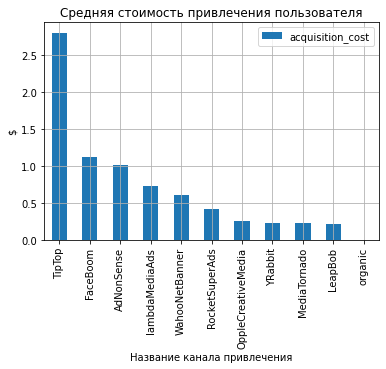

In [48]:
user_counts.plot(kind='bar', grid=True)
plt.title('Средняя стоимость привлечения пользователя')
plt.ylabel('$')
plt.xlabel('Название канала привлечения');

- Самая высокая средняя стоимость привлечения пользователя у канала TipTop
- На втором месте идет канал FaceBoom, у него стоимость привлечения почти в три раза меньше
- На третьем месте по средней стоимости привлечения канал AdNonSense

In [49]:
user_counts = (
profiles.groupby('channel').agg({'acquisition_cost' : 'sum'})
    .sort_values(by='acquisition_cost', ascending=False)
)
user_counts

,acquisition_cost
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


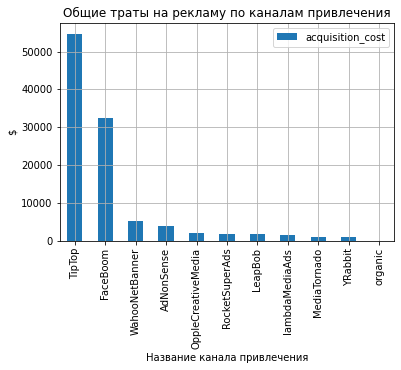

In [50]:
user_counts.plot(kind='bar', grid=True)
plt.title('Общие траты на рекламу по каналам привлечения')
plt.ylabel('$')
plt.xlabel('Название канала привлечения');

По общим тратам, ситуация примерно такая же как и по средним, однако на третьем месте тут канал под названием WahooNetBanner

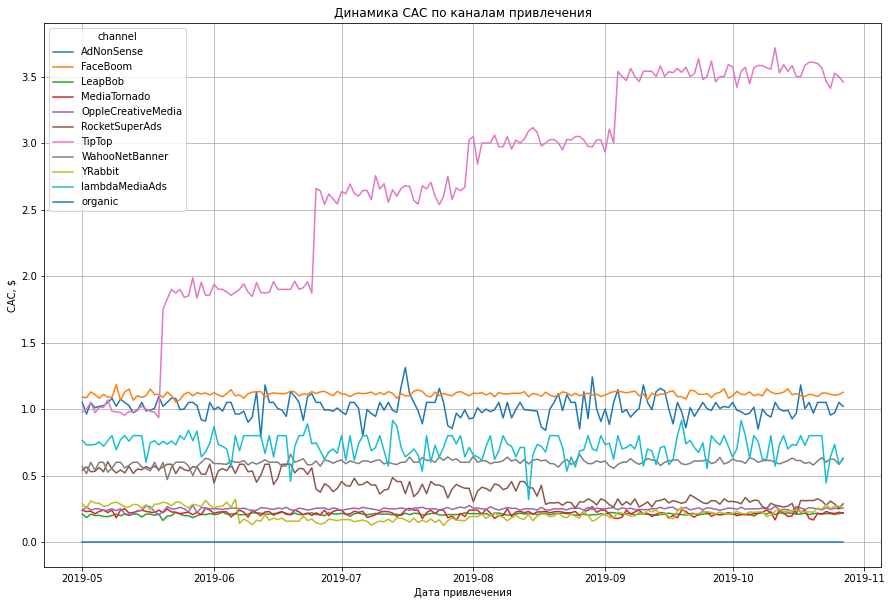

In [51]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Стоиость привлечения (CAC) по всем каналам держится на протяжении времени примерно на одном уровне, где то она выше, где то ниже, но сильно выделяется канал TipTop, на нем CAC к концу 2019 года улетел в небеса и это сильно выделяется на общем фоне. 

Посмотрим далее, окупаются ли вложения в данный канал привлечения, ведь казалось бы, раз он такой "дорого" то это должно чем то обуславливаться?

## Промежуточные выводы

- Всего на рекламу за исследуемый период потрачено: 105497
- Самая высокая средняя стоимость привлечения пользователя у канала TipTop
- На втором месте идет канал FaceBoom, у него стоимость привлечения почти в три раза меньше
- На третьем месте по средней стоимости привлечения канал AdNonSense

Стоиость привлечения (CAC) по всем каналам держится на протяжении времени примерно на одном уровне, где то она выше, где то ниже, но сильно выделяется канал TipTop, на нем CAC к концу 2019 года улетел в небеса и это сильно выделяется на общем фоне.


# Оценка окупаемости рекламы

Предположим, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения

## Анализ общей окупаемости рекламы. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI

Зададим момент и горизонт анализа и уберем органических ползователей, органика это хорошо, они всегда окупаются и повлиять на них мы не можем, посему и исследовать их не будем )

In [52]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа
profiles_no_organic =  profiles.query('channel != "organic"')

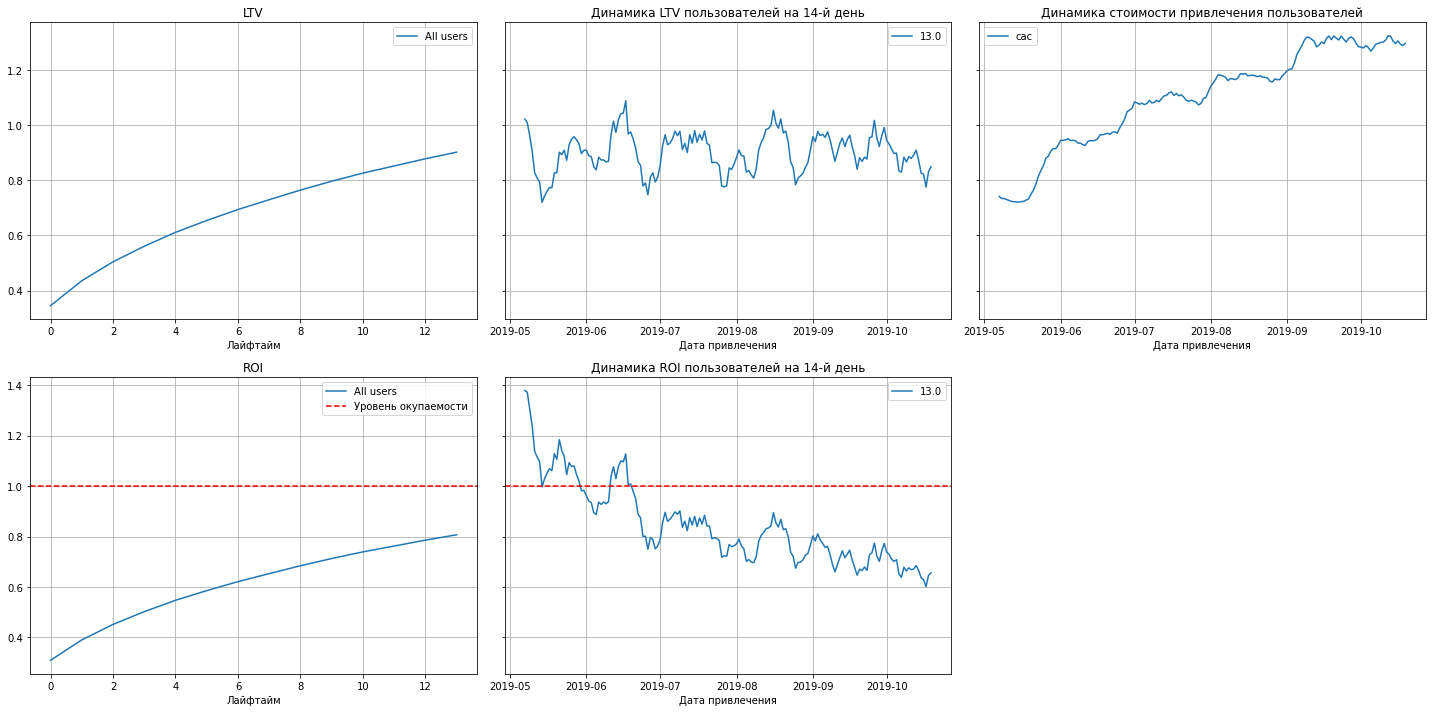

In [53]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

- В целом можно сказать что реклама не окупается. ROI к концу второй недели только лишь приближается к окупаемости, но не пересекает ее. Согласно графику динамики ROI, такая ситуация сложилась начиная с пользователей привлеченных в июне, как раз тогда когда CAC по каналу TipTop резко вырос.
- Сама стоимость привлечения клиентов растет, начиная с июня, при этом ситуация с LTV выглядит более-менее стабильной, хотя и носит сезонный характер.

## Анализ окупаемоси рекламы с разбивкой по рекламным каналам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI

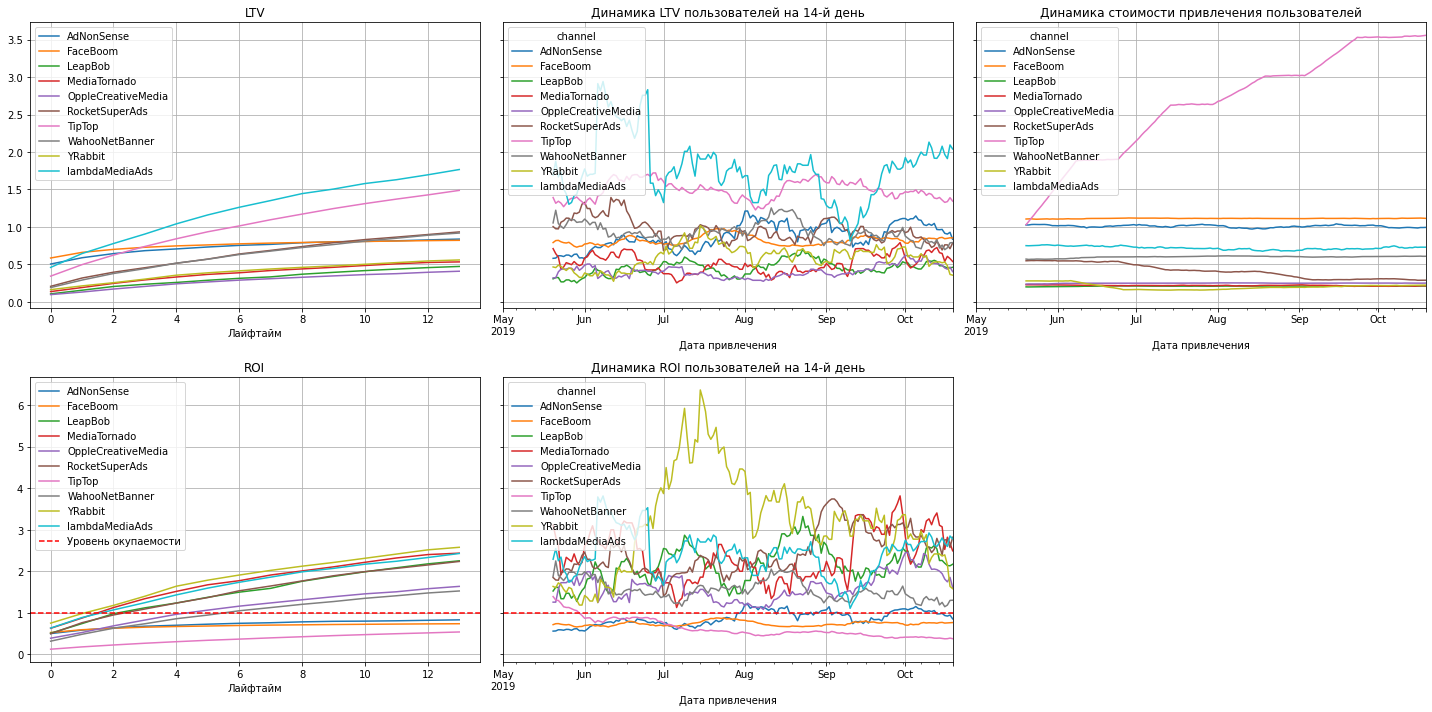

In [54]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
)

- В целом можно сказать что из всех каналов, на окупаемость не входят лишь 3, а именно: TipTop, FAceBoom, AdNonsense, по остальным каналам ситуация выглядит гораздо более радужно, в среднем, юзеры привлеченные из ругих каналов, выходят на окупаемость уже в первую неделю 'жизни'
- Самым высоким LTV обладают пользователи привлеченным из источников LAmbdamediaAds и TipTop
- По стоимости привлечения сильно выделяется TipTop, его CAC постоянно растет, динамика CAC остальных каналов привлечения, на протяжении всего периода исследования, находится на одном уровне. Из самых дорогих можно выделить FaceBoom и ADNonsense, поэтому не удивительно, что пользователи пришедшие из этих источников не окупаются.
- По динамики ROI на 14 день жизни эти три канала так же отличаются от общей массы каналов, почти на всем протяжени периода исследованияя находясь ниже уровня окупаемости лишь изредка слегка пересекая ее. Остальные каналы привлечения на 14 день жизни пользователя окупаются со 100%. 
- Из наиболее окупаемых источников, можно выделить Yrabbit (правда его окупаемость упала к концу года, но в середине года имела просто огромную окупаемость на 14 день) MediaTornado LambdaMediaArts

- Хуже всех показывает себя TipTiop

## Анализ окупаемоси рекламы с разбивкой по странам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI

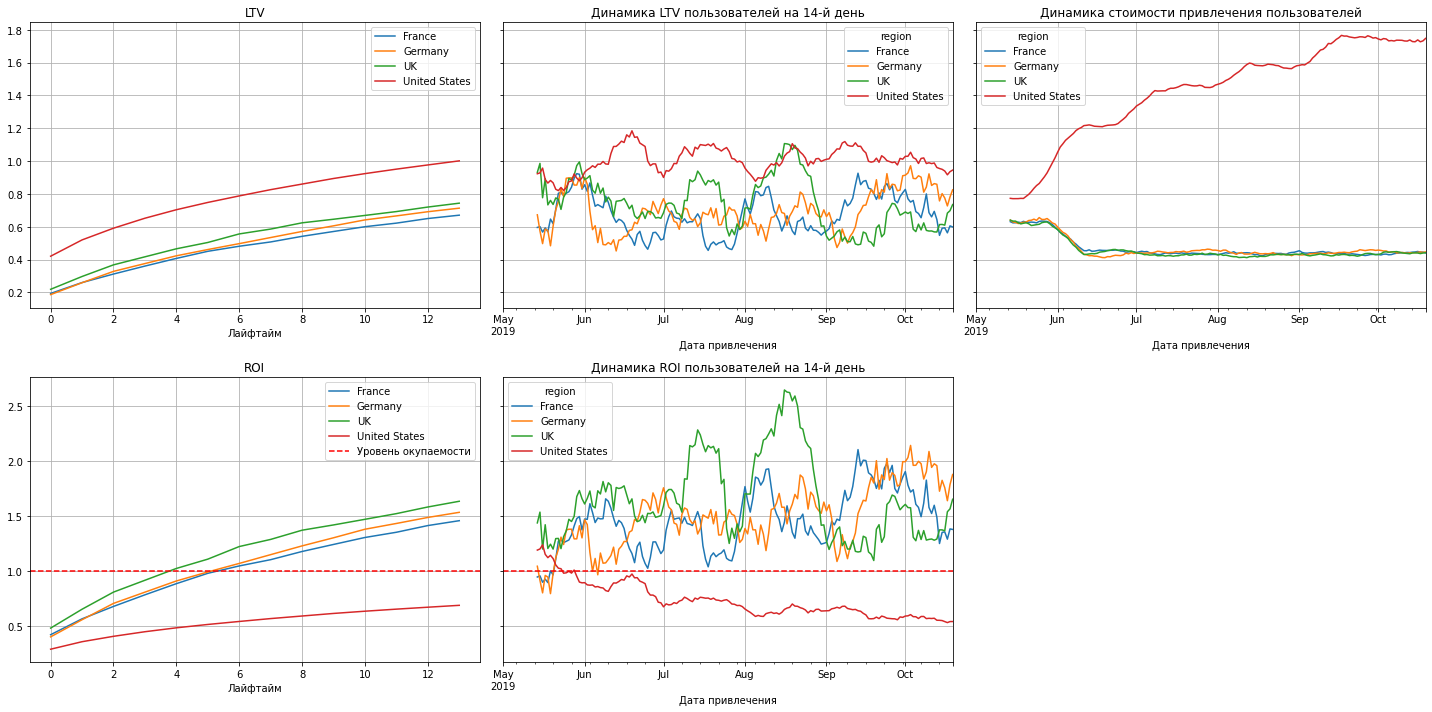

In [55]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Явно видна какая то проблема со стороны пользователей из Америки, хоть эти пользователи и имеют самый высокий LTV с первого по 14 день, однако на уровень окупаемости они так и не выходят, причем динамика LTV юзеров из Америки, носит такой же стабильной, хотя и подверженный сезонности, характер. Так же пользователи из Америки имеют самую высокую стоиомсть привлечения, которая продалжает расти, а ROI этих пользователей продалжает падать.

По остальным странам в целом все более менее в порядке, пользователи из других стран выходят на окупаемость примерно на 4-5 день "жизни", и их ROI растет и в 14 лайфтайм находится выше уровня окупаемости. Динамика LTV этих регионов носит так же сезонный характер, но в целом более менее стабильна, CAC находится +/- на одном уровне.

Стоит так же отметить, что лучше всего окупаются пользователи из Англии, затем идет Германия, а потом Франция

## Анализ окупаемоси рекламы с разбивкой по устройствам. Графики LTV и ROI, а также графики динамики LTV, CAC и ROI

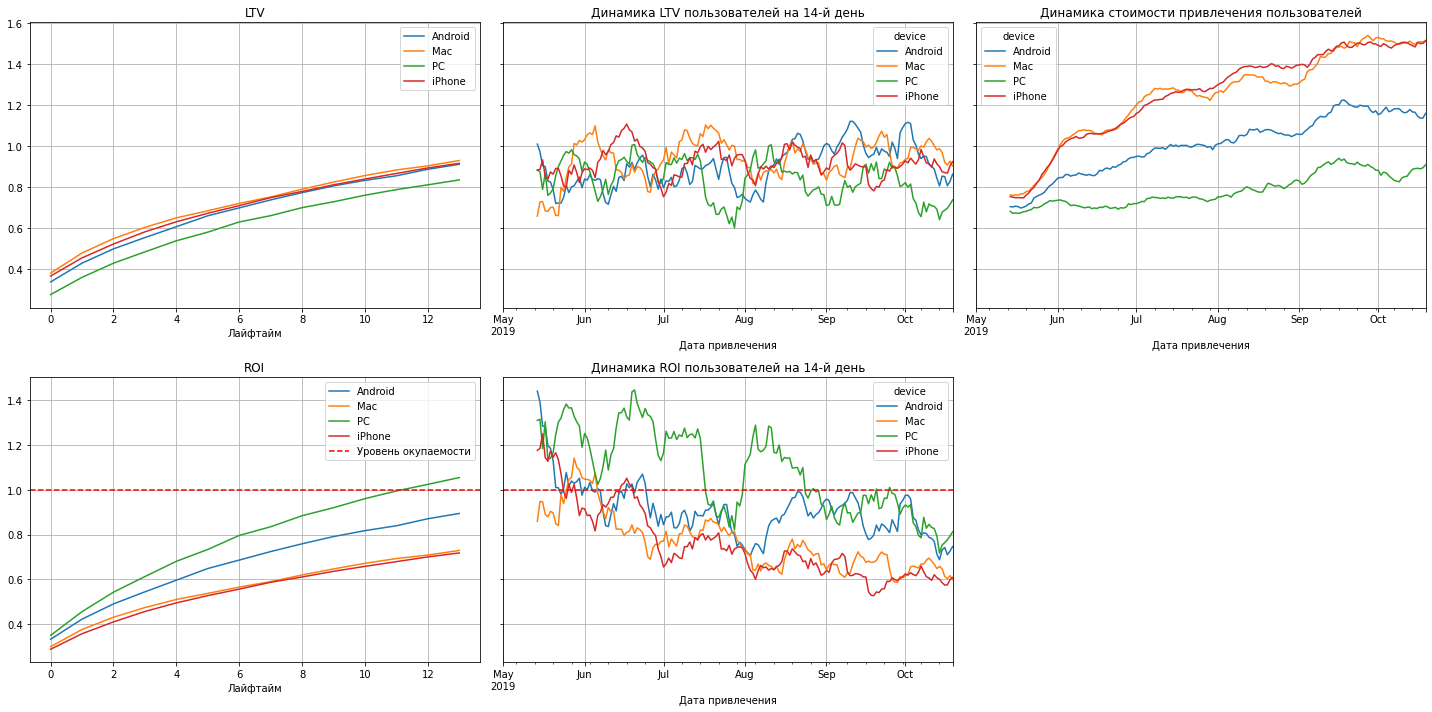

In [56]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В целом ситуация в разрезе устройств выглядит печально, так как реклама в целом не окупается, то и в зависимости от устройств сложно было ожидать какого-то чуда. Разве что можно выделить что пользователи копьютеров единственные кто выходит на окупаемость к 14 дню жизни

## Графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам

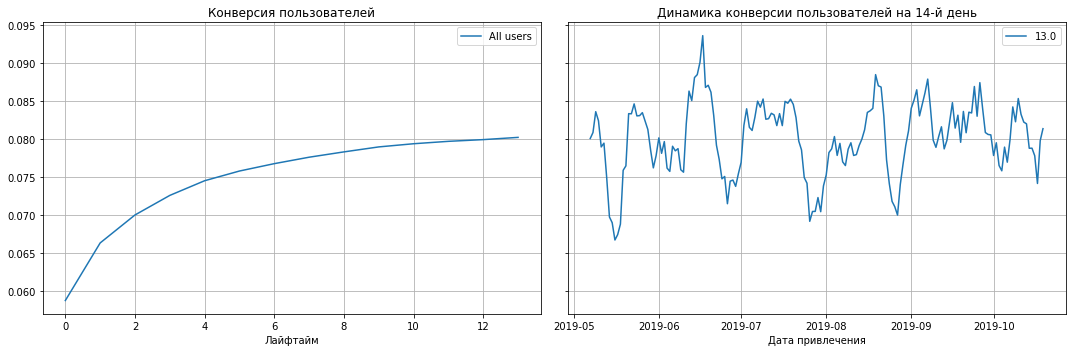

In [57]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия к 14 дню жизни достигает около 8% и сильно замедляет свой рост. Динамика конверсии на 14 день жизни скачет между 7,5 - 8,5% в зависимости от даты привлечения, но в целом, можно сказать что находится в среднем на одном уровне, изредка проседая до 7%.

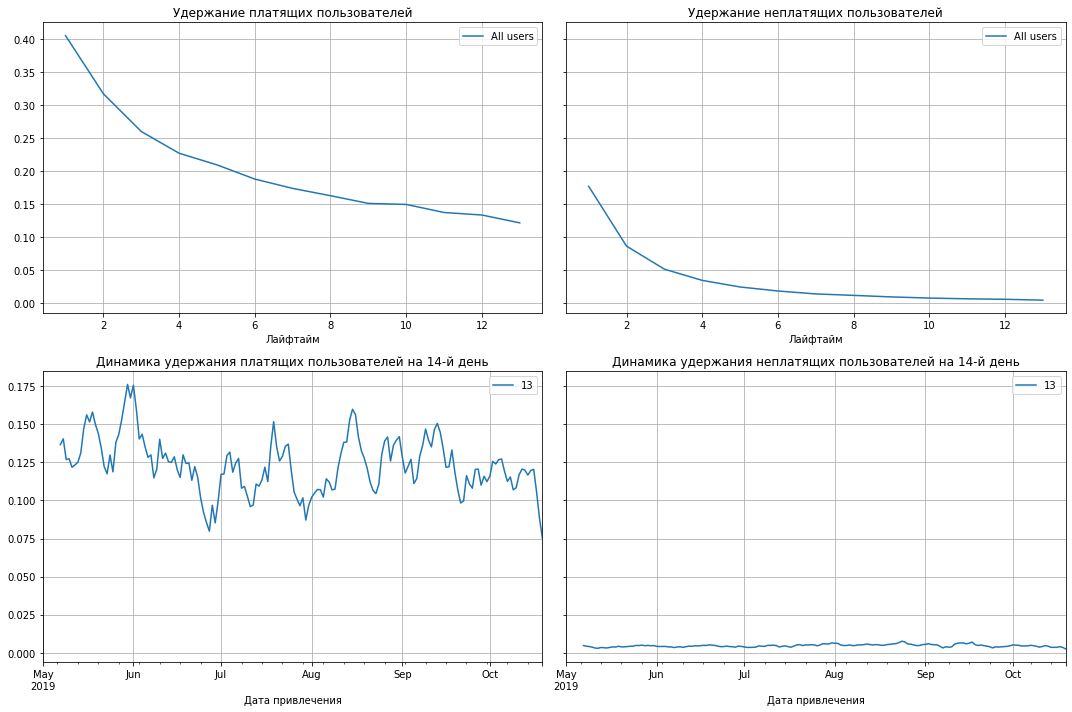

In [58]:
retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions=[],
    ignore_horizon=False)
plot_retention(retention_grouped, retention_history, horizon_days, window=7)

Удержание платящих пользователей намного выше чем неплатящих, что собственно не удивительно. Судя по динамики, наблюдается небольшой спад retention с мая по октябрь, с 0,175 в пике до примерно 0,110 в среднем к концу исследуемого периода

In [74]:
dimensions = ['device']

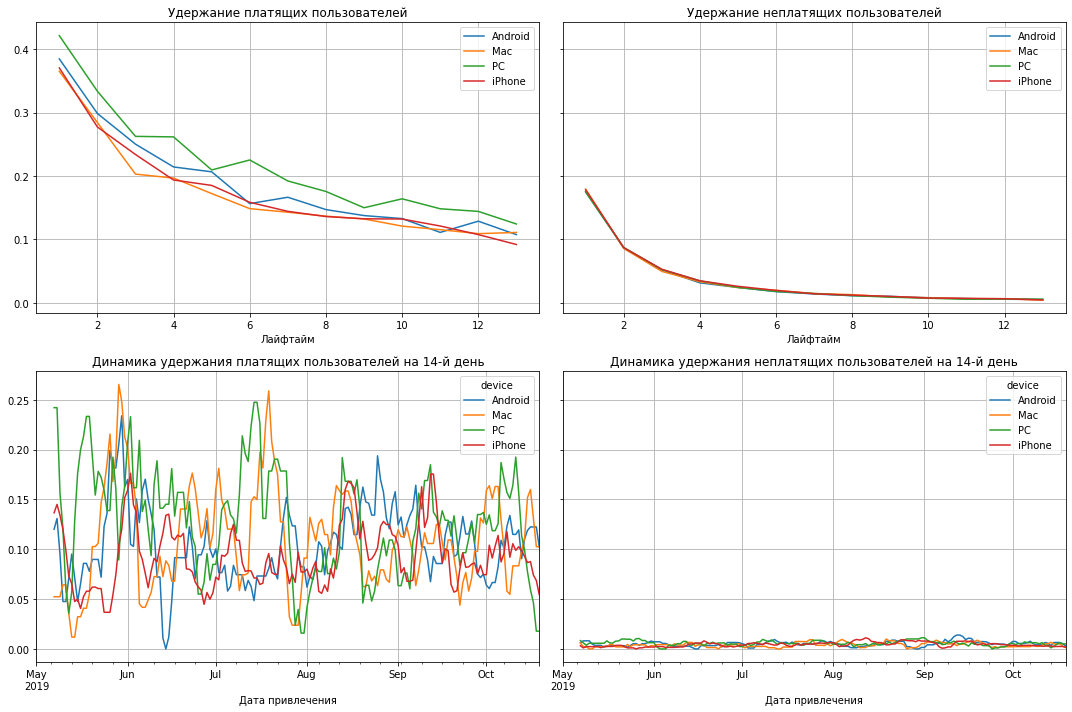

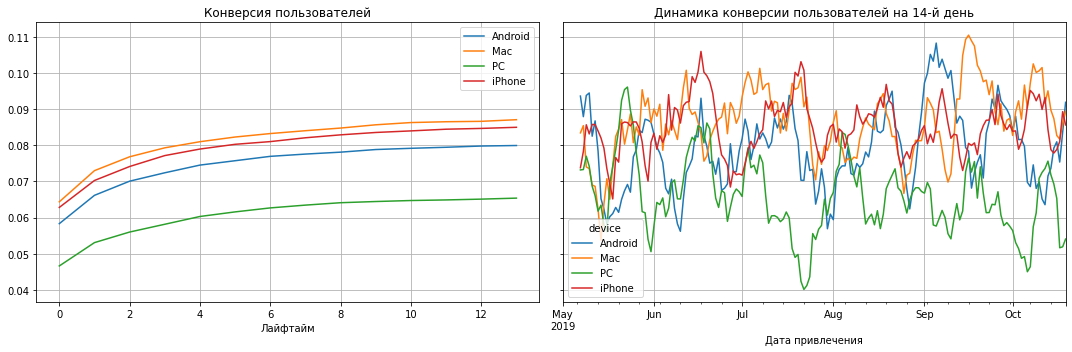

In [75]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

В графиках удержания пользователей, относительно устройств, можно сказать что в целом особых отличий нет, удержание платящих пользователей с компютеров в целов немного выше чем удержание платящих пользователей по остальным девайсам

Хоть пользователи с компьютеров и лучше всего удерживаются, однако они хуже всех конвертируются, лучшей конверсией на 14 день жизни обладают пользователи Mac

In [62]:
dimensions = ['channel']

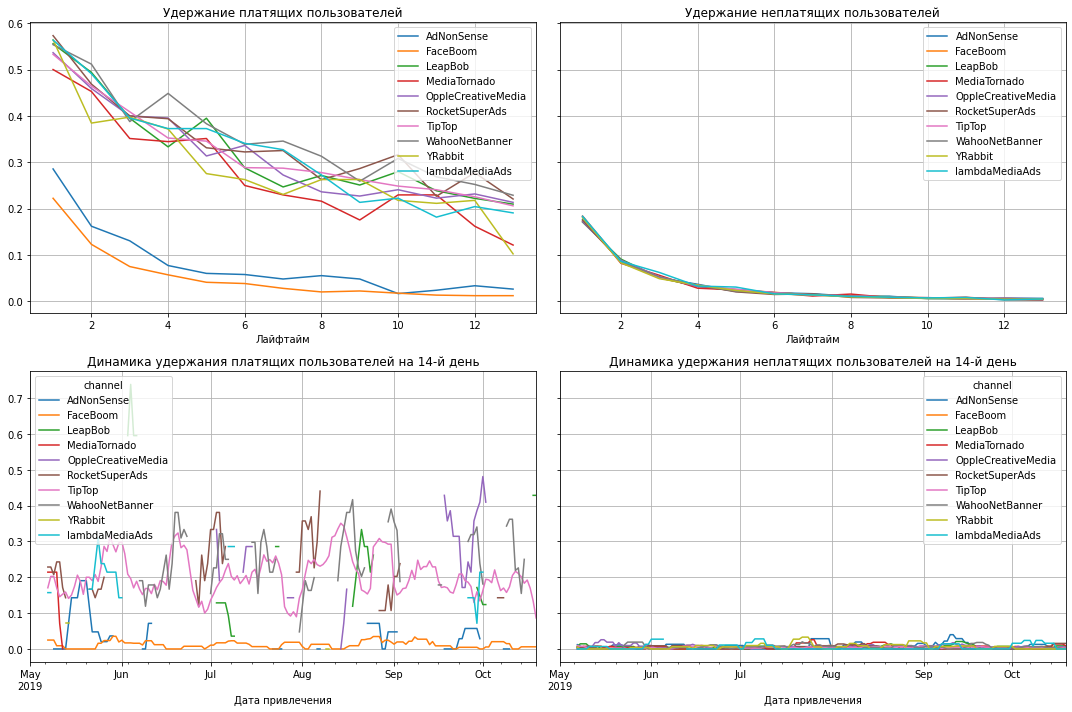

In [63]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание в разрезе каналов привлчения в целом находится на одном уровне по каждому каналу, однако тут присутсвуют два явных аутсайдера - AdNonSense и FaceBoom.

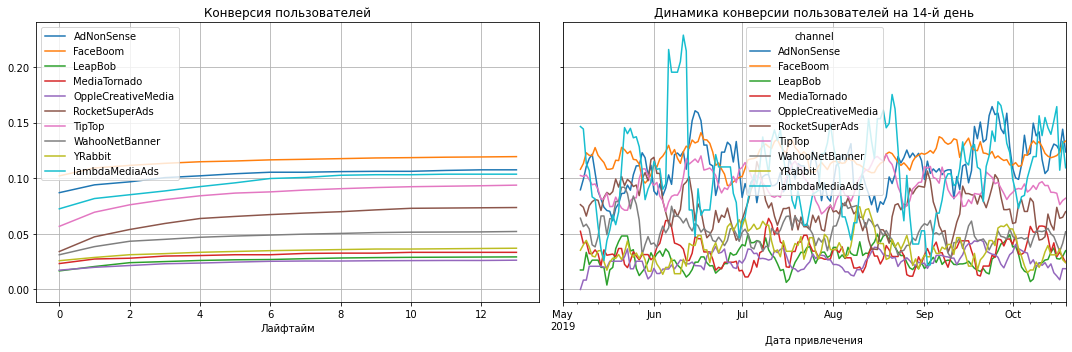

In [64]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Однако эти же два канала имеют самую высокую конверсию пользователей на 14 день жизни. НА третьем месте идем LambdaMediaArts на четвертом TipTop. Хуже всех конвертируются пользователи пришедшие из OppleCreativeMedia

In [65]:
dimensions = ['region']

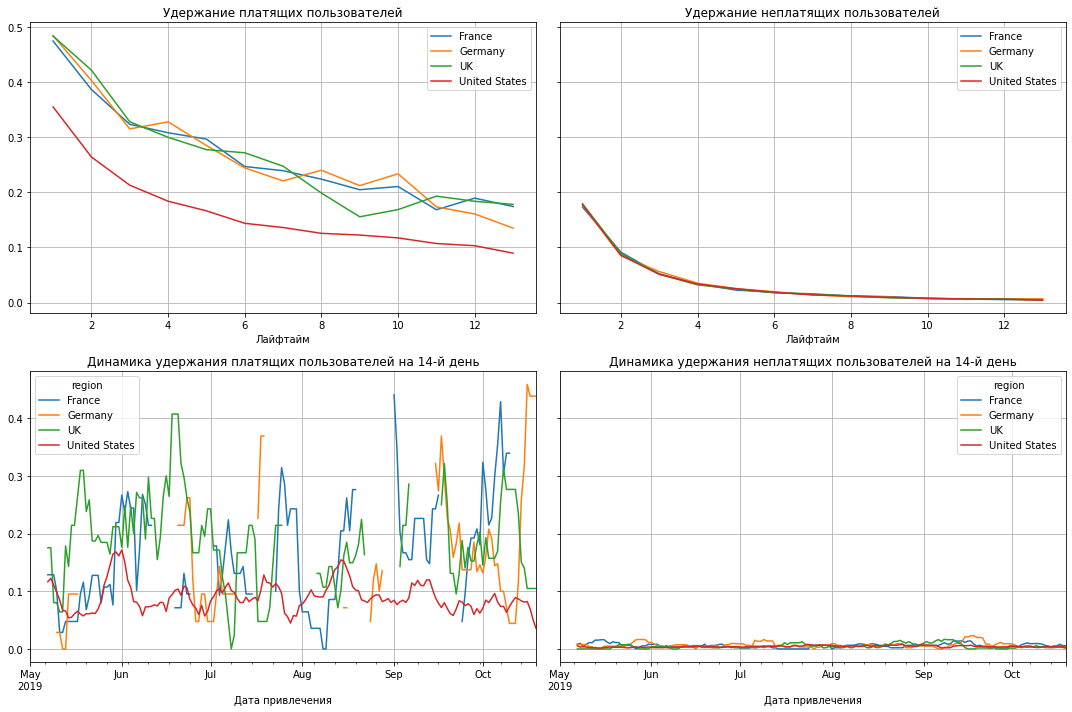

In [66]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_organic, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Страны Европы удерживаются гораздо лучше чем Америка.

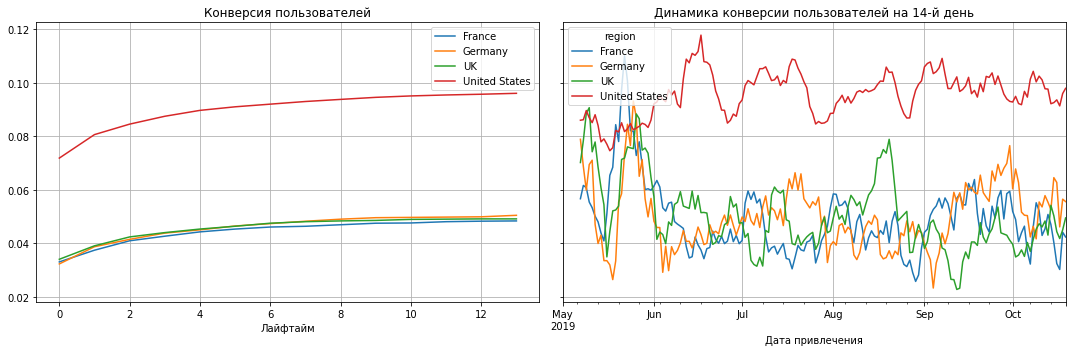

In [67]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_no_organic, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

## Промежуточный вывод

Конверсия по всем пользователям (кроме органических) к 14 дню жизни достигает около 8% и сильно замедляет свой рост. Динамика конверсии на 14 день жизни скачет между 7,5 - 8,5% в зависимости от даты привлечения, но в целом, можно сказать что находится в среднем на одном уровне, изредка проседая до 7%.

Удержание платящих пользователей намного выше чем не платящих, что собственно не удивительно. Судя по динамики, наблюдается небольшой спад retention с мая по октябрь, с 0,175 в пике до примерно 0,110 в среднем к концу исследуемого периода



Судя по графикам удержания пользователей, относительно устройств, можно сказать что в целом особых отличий нет, удержание платящих пользователей с компьютеров в целом немного выше чем удержание платящих пользователей по остальным девайсам.

Хоть пользователи с компьютеров и лучше всего удерживаются, однако они хуже всех конвертируются, лучшей конверсией на 14 день жизни обладают пользователи Mac.

Удержание в разрезе каналов привлечения в целом находится на одном уровне по каждому каналу, однако тут присутствуют два явных аутсайдера - AdNonSense и FaceBoom.

Однако эти же два канала имеют самую высокую конверсию пользователей на 14 день жизни. На третьем месте идем LambdaMediaArts на четвертом TipTop. Хуже всех конвертируются пользователи пришедшие из OppleCreativeMedia.

Страны Европы удерживаются гораздо лучше чем Америка.

Но при этом и конвертируются гораздо хуже.

# Ответы на поставленные вопросы:

**Окупается ли реклама в целом?**

Реклама в целом не окупается.  Скорее всего причина в неправильно выбранных источниках привлечения, такие каналы как TipTop, FAceBoom, AdNonsense так и не вышли на уровень окупаемости. Хоть пользователи из TipTop и имеют самый высокий LTV, но в связи с постоянным ростом CAC этого источника, пользователи из нее не окупаются никогда.



**Какие устройства, страны и каналы могут снижать окупаемость рекламы?**

Явно видна какая то проблема со стороны пользователей из Америки, хоть эти пользователи и имеют самый высокий LTV с первого по 14 день, однако на уровень окупаемости они так и не выходят, причем динамика LTV юзеров из Америки, носит такой же стабильной, хотя и подверженный сезонности, характер. Так же пользователи из Америки имеют самую высокую стоимость привлечения, которая продолжает расти, а ROI этих пользователей продолжает падать.  Стоит отметить, что в данном регионе, основными источниками привлечения, служат каналы TipTop и Faceboom - как раз те источники, которые окупаются хуже всех. 

Выделить какие то особые проблемы в устройствах не получается, в общем контексте не окупаемости рекламы, не окупаются почти все девайсы, разве что пользователи компьютеров с горем пополам выходят на окупаемость ко второй недели жизни.



**Возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела**

Основная причина неэффективной маркетинговой компании, в неправильно выбранных источниках привлечения, а так же в том что не уследили за ростом стоимости привлечения в TipTop что и привело к неудовлетворительным финансовым результатам.

# Проверка гиппотезы о неудачных каналах привлечения в Америке

In [72]:
profiles_no_organic_america = profiles_no_organic[profiles_no_organic['region'] == 'United States']
profiles_no_organic_america.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
8,58263264,2019-05-11 19:18:43,FaceBoom,iPhone,United States,2019-05-11,2019-05-01,False,1.128205
9,59835779,2019-05-11 21:13:47,MediaTornado,iPhone,United States,2019-05-11,2019-05-01,False,0.250435


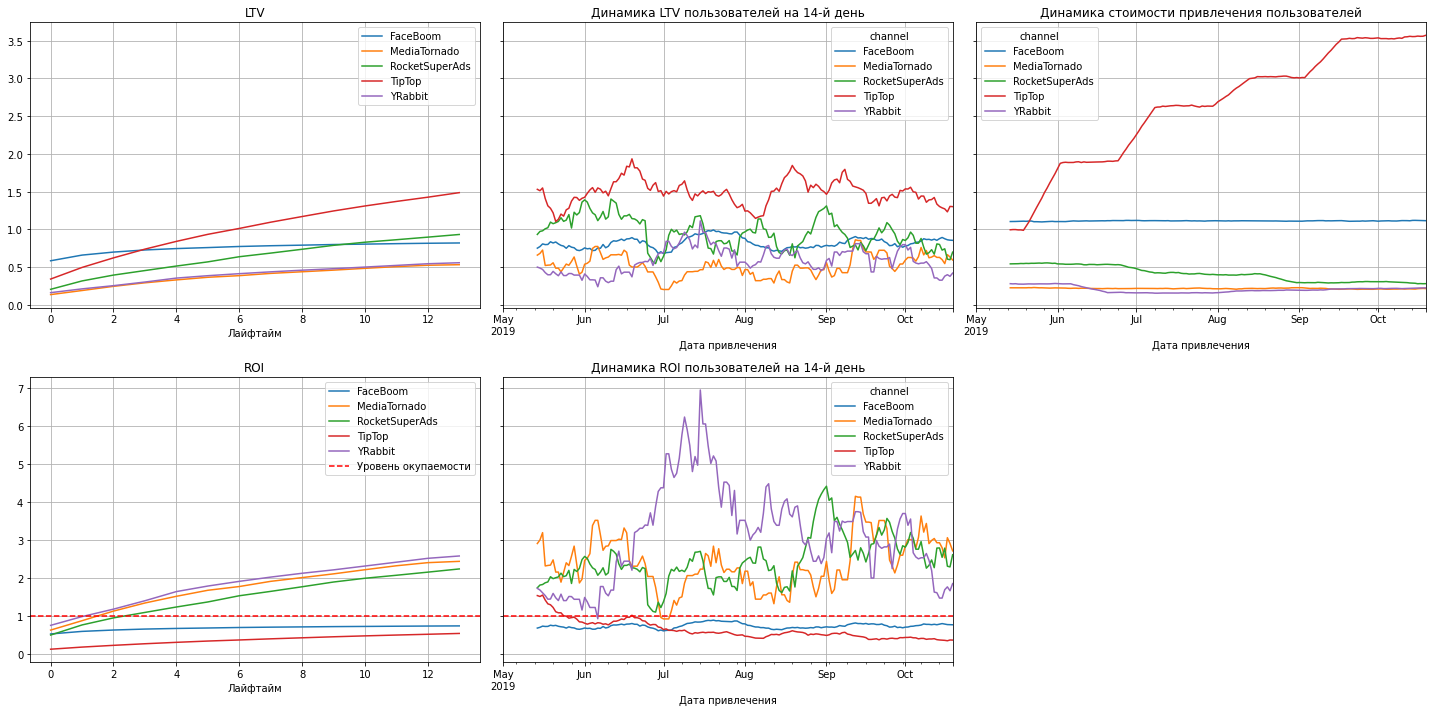

In [88]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic_america, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Глянем ближе

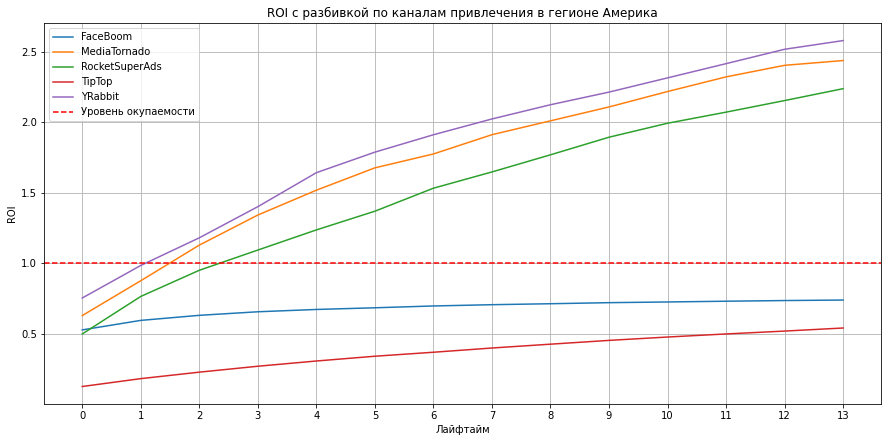

In [89]:
report = roi_grouped.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(15, 7), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения в гегионе Америка')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

In [90]:
profiles_no_organic_eourope = profiles_no_organic[profiles_no_organic['region'] != 'United States']
profiles_no_organic_eourope.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
7,46006712,2019-06-30 03:46:29,AdNonSense,Android,France,2019-06-30,2019-06-01,True,1.008000
17,93828625,2019-07-24 05:56:22,LeapBob,iPhone,Germany,2019-07-24,2019-07-01,False,0.204324
24,138399008,2019-07-20 16:59:16,WahooNetBanner,PC,UK,2019-07-20,2019-07-01,False,0.635294
42,267553828,2019-09-21 12:17:42,WahooNetBanner,PC,France,2019-09-21,2019-09-01,False,0.591304


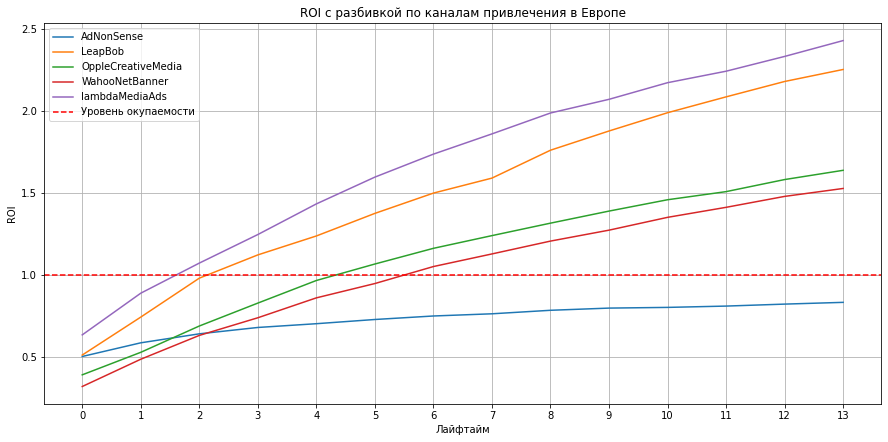

In [91]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_organic_eourope, orders, observation_date, horizon_days, dimensions=dimensions
)

report = roi_grouped.drop(columns=['cohort_size', 'cac'])
report.T.plot(grid=True, figsize=(15, 7), xticks=list(report.columns.values))

plt.title('ROI с разбивкой по каналам привлечения в Европе')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

# Общий вывод
6.1. Выделите причины неэффективности привлечения пользователей.
6.2. Сформулируйте рекомендации для отдела маркетинга.

**Про пользователей**

- Больше всего пользователей из Америки, больше чем 100к, в этом же регионе больше всего платящих пользователей и самая высокая конверсия - 6,9%. Данный регион имеет почти 70% всех пользователей приложения и почти 80% всех платящих пользователей.

- На втором месте по количеству пользователей и платящих пользователей идет Англия, однако по конверсии данный регион занимает 3-е место

- Франция по количеству пользователей и платящих пользователей находится на третьем мест и конвертируется хуже всех

- В Германии меньше всех пользователей всех видов, однако конверсия выше чем у Франции



У Англии, Франции и Германии примерно по 10 - 11% пользователей от общего количества и от 7-8% платящих от общего количества платящих пользователей



- Наибольшее число пользователей, предпочитают IPhone, с этого же устройства заходят в приложения и большинство платящих юзеров по количеству, но не по конверсии. Первое место по конверсии занимают пользователи MAC.

- На втором месте по обоим показателям (общее количество и количество платящих пользователей) занимает Android, по конверсии данная платформа на 3-ем месте.

- На третьем месте идет Mac, но у него самая высокая конвертируемость в платных юзеров.

- PC на последнем месте по всем показателям



Если смотреть в разрезе регионов, то ситуация следующая:

- В Америки предпочитают Iphone, но лучше всего конвертируются с Android

- В Европе больше всего пользователей на ПК, и они же, везде, кроме Франции, лучше всего конвертируются.



- Удивительно, но больше всего пользователей пришло в приложение самостоятельно, это очень хорошо, ведь они бесплатные и около 2% из них совершили покупку.

- На втором месте по количеству привлеченных пользователей FaceBoom, так же из этого канало поступило больше всего платящих пользователей, канал имеет одну из самых высоких стоимостей привлечения, но зато самую высокую конверсию

- TipTop занимает третье место по количеству привлеченных пользователей, но этот канал привлечения имеет самую высокую стоимость привлечечния среди всех и далеко не самую лучшую конверсию. Позже глянем на окупаемость



Основными каналами привлечения для США являются:

- Faceboom  - больше всех привлеченных клиентов среди платных источников, имеет самую высокую конверсию в США

- TipTop второе место по количеству привлеченных клиентов и почти 10% конверсии

- И на удивление, больше всего клиентов - бесплатные, самопришедшие ) Правда конверсия там всего 2%, зато бесплатно :)



В Европе (Англия, Германия, Франция):

- WahooNetBanner топ платформа по привлечению, но с небольшим выхлопом, всего 5% конверсии

- AdNonSense почти в три раза меньше привлеченных клиентов чем у первого места, но зато очень высокая конверсия - 11,43%

- И так же как и у Америки, больше всего пришло клиентов самостоятельно, с такой же конверсией - 2%



**Про маркетинг**

- Всего на рекламу за исследуемый период потрачено: 105497

- Самая высокая средняя стоимость привлечения пользователя у канала TipTop

- На втором месте идет канал FaceBoom, хотя у этого канала стоимость привлечения почти в три раза меньше чем у первого места

- На третьем месте по средней стоимости привлечения канал AdNonSense



Стоимость привлечения (CAC) по всем каналам держится на протяжении времени примерно на одном уровне, где то она выше, где то ниже, но сильно выделяется канал TipTop, на нем CAC к концу 2019 года улетел в небеса и это сильно выделяется на общем фоне.



**Про окупаемость**

- В целом можно сказать что из всех каналов, на окупаемость не входят лишь 3, а именно: TipTop, FAceBoom, AdNonsense, по остальным каналам ситуация выглядит гораздо более радужно, в среднем, юзеры привлеченные из других каналов, выходят на окупаемость уже в первую неделю 'жизни'

- Самым высоким LTV обладают пользователи привлеченным из источников LAmbdamediaAds и TipTop

- По стоимости привлечения сильно выделяется TipTop, его CAC постоянно растет, динамика CAC остальных каналов привлечения, на протяжении всего периода исследования, находится на одном уровне. Из самых дорогих можно выделить FaceBoom и ADNonsense, поэтому не удивительно, что пользователи пришедшие из этих источников не окупаются.

- По динамики ROI на 14 день жизни эти три канала так же отличаются от общей массы каналов, почти на всем протяжени периода исследованияя находясь ниже уровня окупаемости лишь изредка слегка пересекая ее. Остальные каналы привлечения на 14 день жизни пользователя окупаются со 100%.  

- Из наиболее окупаемых источников, можно выделить Yrabbit (правда его окупаемость упала к концу года, но в середине года имела просто огромную окупаемость на 14 день) MediaTornado LambdaMediaArts

- Хуже всех показывает себя TipTiop



Явно видна какая то проблема со стороны пользователей из Америки, хоть эти пользователи и имеют самый высокий LTV с первого по 14 день, однако на уровень окупаемости они так и не выходят, причем динамика LTV юзеров из Америки, носит такой же стабильной, хотя и подверженный сезонности, характер. Так же пользователи из Америки имеют самую высокую стоимость привлечения, которая продолжает расти, а ROI этих пользователей продолжает падать.



По остальным странам в целом все более менее в порядке, пользователи из других стран выходят на окупаемость примерно на 4-5 день "жизни", и их ROI растет и в 14 лайфтайм находится выше уровня окупаемости. Динамика LTV этих регионов носит так же сезонный характер, но в целом более менее стабильна, CAC находится +/- на одном уровне.



Стоит так же отметить, что лучше всего окупаются пользователи из Англии, затем идет Германия, а потом Франция.



В целом ситуация в разрезе устройств выглядит печально, так как реклама в целом не окупается, то и в зависимости от устройств сложно было ожидать какого-то чуда. Разве что можно выделить что пользователи компьютеров единственные кто выходит на окупаемость к 14 дню жизни.



**Про конверсию и retention**

Конверсия по всем пользователям (кроме органических) к 14 дню жизни достигает около 8% и сильно замедляет свой рост. Динамика конверсии на 14 день жизни скачет между 7,5 - 8,5% в зависимости от даты привлечения, но в целом, можно сказать что находится в среднем на одном уровне, изредка проседая до 7%.

Удержание платящих пользователей намного выше чем не платящих, что собственно не удивительно. Судя по динамики, наблюдается небольшой спад retention с мая по октябрь, с 0,175 в пике до примерно 0,110 в среднем к концу исследуемого периода



Судя по графикам удержания пользователей, относительно устройств, можно сказать что в целом особых отличий нет, удержание платящих пользователей с компьютеров в целом немного выше чем удержание платящих пользователей по остальным девайсам.

Хоть пользователи с компьютеров и лучше всего удерживаются, однако они хуже всех конвертируются, лучшей конверсией на 14 день жизни обладают пользователи Mac.



Удержание в разрезе каналов привлечения в целом находится на одном уровне по каждому каналу, однако тут присутствуют два явных аутсайдера - AdNonSense и FaceBoom.

Однако эти же два канала имеют самую высокую конверсию пользователей на 14 день жизни. На третьем месте идем LambdaMediaArts на четвертом TipTop. Хуже всех конвертируются пользователи пришедшие из OppleCreativeMedia.



Страны Европы удерживаются гораздо лучше чем Америка.

Но при этом и конвертируются гораздо хуже.

## Причины и промежуточные рекомендации

Основная причина неэффективной маркетинговой компании, в неправильно выбранных источниках привлечения, а так же в том что не уследили за ростом стоимости привлечения в TipTop что и привело к неудовлетворительным финансовым результатам. **Рекомендую сменить маркетинговую политику в Америке и отказаться от таких источников привлечения как TipTop, FaceBoom и обратить внимание на такие каналы как Yrabbit, MediaTornado и RocketSuperStar, как топ 3 канала по окупаемости в Америке. В Европейском регионе стоит отказаться от AdNonsense и поискать вместо него другой источник привлечения, но лучше всех LambdaMediaArts и LeapBob.** Америка в целом довольно перспективный регион и наше приложение там определенно имеет успех, стоит его закрепить изменив маркетинговую компанию